<h2 style='font-size:30px'>Loading and Scaling the Dataset </h2>

In [73]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

# Loading the data..
X,y = load_breast_cancer(return_X_y=True)

# Splitting the training and test sets and scaling the numbers.
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

<h2 style='font-size:30px'> Outlier Detection and Removal</h2>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            For this section, I will carry out the exclusion of outliers for each cell class. It would not be reasonable to perform it in the whole training set since the objects under analysis have different properties.
        </li>
    </ul>
</div>

<h3 style='font-size:30px;font-style:italic'> Malign Outliers Treatment</h3>

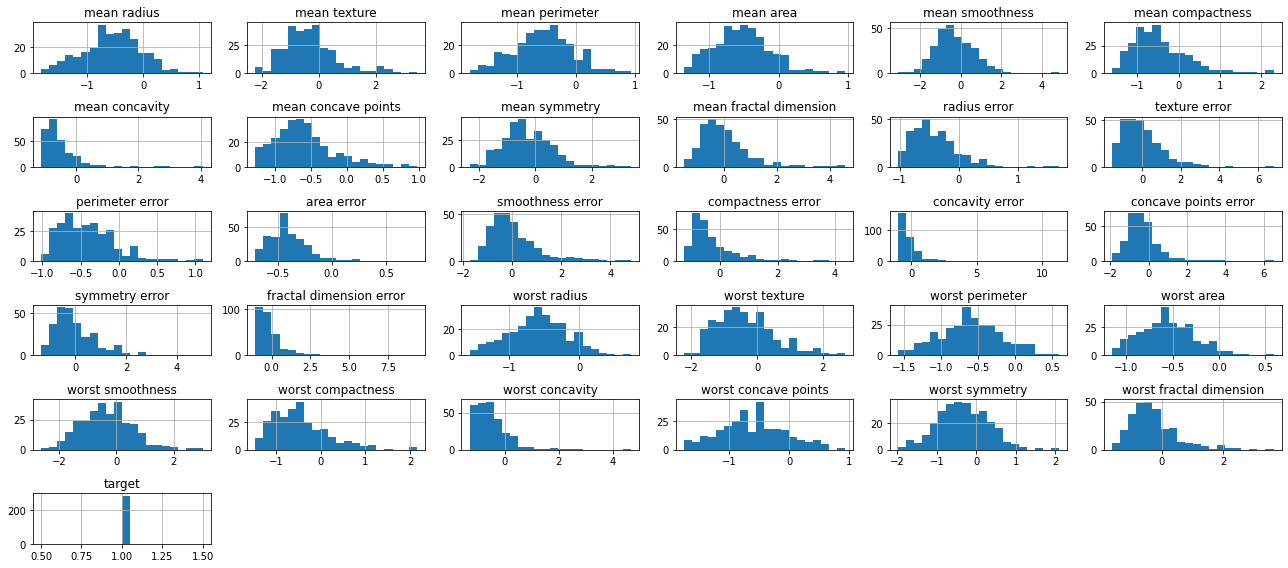

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

# I am invoking 'load_breast_cancer' again so that we can get the feature names.
breast_cancer = load_breast_cancer()
train = pd.DataFrame(np.concatenate((X_train_scaled, y_train.reshape(-1,1)), axis=1),
                    columns=np.append(breast_cancer['feature_names'], 'target'))

# Obtaining exclusively the malign cells data.
malign = train[train.target==1]
malign.hist(bins=20, figsize=(18,8));
plt.tight_layout()

<div> 
    <ul style='font-size:20px'> 
        <li> 
            There are two major shapes in our histograms. Most of them resemble a Normal Distribution, with its values converging to a common number, whereas other features look most like a Chi-Square Distribution.
        </li>
    </ul>
</div>

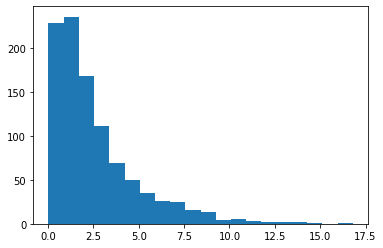

In [111]:
# Plotting a 2.5 Degrees of Freedom Chi-Square Distribution. Note that its shape is similar with some of the plots of the figure above.
plt.hist(np.random.chisquare(2.5, 1000).reshape(-1,1), bins=20);

<h4 style='font-size:30px;font-style:italic;text-decoration:underline'> Chi-Square Features Treatment</h4>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            As the chart just created presents, chi-square distributions tend to have most of their values concentrated on the left portion of the x-axis; as we move toward the right section, the values become scarcer. In the setting of a ML project, it is not interesting to keep such rare numbers in our dataset, they need to be removed so that the algorithms can achieve greater performances.
        </li>
    </ul>
</div>

In [155]:
# Let's list all the columns that appear to approximately have the shape of a Chi-Squared Distribution.
chi_sqr = ['mean concavity', 'compactness error', 'concavity error',  'fractal dimension error','worst concavity']

# Removing all the lines which cells are considered outliers in any of the features from 'chi_sqr' list (using the IQR technique).
maling_chi_sqr = malign[chi_sqr]
iqr = 1.5 * np.percentile(maling_chi_sqr, 75, axis=0) - np.percentile(maling_chi_sqr, 25, axis=0)
keep_maling_chi_sqr = maling_chi_sqr[(maling_chi_sqr < iqr).any(axis=1)].index

<h4 style='font-size:30px;font-style:italic;text-decoration:underline'> Normal Distributed Features Treatment</h4>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Now, the majority of the columns reveals the format of a Normal Distribution. Unlike the previous section, the IQR procedure needs to be applied for both left and right areas around the mean value.
        </li>
    </ul>
</div>

In [171]:
# Listing all the normal distributed features.
normal = list(malign.columns)
for col in chi_sqr:
    normal.remove(col)
normal.remove('target')

In [237]:
# Sectioning the 'malign' DataFrame with 'normal'.
malign_normal = malign[normal]
# Now, deleting rows based on the IQR rule:
iqr = 1.5 * (malign_normal.quantile(.75) - malign_normal.quantile(.25)) 

# 'to_drop1' mentions all the rows that have one of its values below the 25th quantile - IQR of any given column.
to_drop1 = ((malign_normal < malign_normal.quantile(.25) - iqr)
            .any(axis=1)
            .where(lambda x: x==True)
            .dropna()
            .index)

# 'to_drop2' presents the rows which values exceed the 75th quantile + IQR of any given column.
to_drop2 = ((malign_normal > malign_normal.quantile(.75) + iqr)
            .any(axis=1)
            .where(lambda x: x==True)
            .dropna()
            .index)
# Continuar daqui!!!


In [18]:
# The reason of choosing XGBoost as our feature selection classifier was its usual high performance in most of the projects and also
# the fact that it presents the convenient 'feature_importances' attribute.

from keras_tuner import SklearnTuner, HyperParameters
from keras_tuner.oracles import BayesianOptimization
from xgboost import XGBClassifier


# Constructing the algorithm.
def build_model(hp):
    model = XGBClassifier(
        n_estimators = hp.Int('n_estimators', min_value=30, max_value=100, step=10),
        max_depth = hp.Int('max_depth', min_value=2, max_value=4, step=1),
        gamma = hp.Float('gamma', min_value=.05, max_value=.5, step=.05),
        colsample_bytree = hp.Float('colsample_bytree', min_value=.1, max_value=.5, step=.1)
        )
    return model

In [71]:
# Now, let's use K-Means
import numpy as np
from sklearn.metrics import silhouette_score

# 'n_clusters' holds the different 'n_clusters' values that will be used; 'silhouette' keeps the corresponding Silhouette Scores achieved
# in each iteration.
n_clusters = []
silhouetes = []
for i in range(2,11):
    predictions = KMeans(n_clusters=i, random_state=42).fit_predict(X_train_scaled)
    silhouette = silhouette_score(X_train_scaled, predictions)
    n_clusters.append(i)
    silhouetes.append(silhouette)

In [72]:
# What as the best 'n_clusters' number?
idx = np.argmax(silhouetes)
best_n_clusters = n_clusters[idx]

best_n_clusters

2

<p style='color:red'> Remover outliers dist normal com as listas 'to_drop'. Depois montar a Bayesian Opt</p>
<p> https://keras.io/api/keras_tuner/tuners/sklearn/</p>
<p>https://keras.io/guides/keras_tuner/tailor_the_search_space/ </p>